## RUN ONCE
Run this code snippet to create a directory to store the GT images.

In [15]:
import os
if not os.path.exists('ball_frames_gt'):
    os.makedirs('ball_frames_gt')

if not os.path.exists('ball_frames_masks'):
    os.makedirs('ball_frames_masks')

for img in os.listdir('ball_frames'):
    if img.endswith('_GT.png'):
        os.rename(f'ball_frames/{img}', f'ball_frames_gt/{img}')

## Task 1a

In [3]:
import cv2
import numpy as np

def balls_segment(image, kernel_size=5, area_min=200, area_max=3000):
    grey_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gauss_image = cv2.GaussianBlur(grey_image, (kernel_size, kernel_size), sigmaX=5, sigmaY=5)
    threshold_image = cv2.threshold(gauss_image, 150, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    threshold_image = 255 - threshold_image[1]
    image_contours = cv2.findContours(threshold_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(image_contours) == 2:
        image_contours = image_contours[0] 
    else: 
        image_contours=image_contours[1]

    v_contours = []
    for con in image_contours:
        con_area = cv2.contourArea(con)
        x, y, width, height = cv2.boundingRect(con)
        w_to_h_ratio = float(width) / height
        if area_min < con_area < area_max and 0.9 < w_to_h_ratio < 1.9:
            v_contours.append(con)

    ball_masks = np.zeros_like(threshold_image, dtype=np.uint8)

    cv2.drawContours(ball_masks, v_contours, -1, (255, 255, 255), -1)
    enlarge_kernel = np.ones((kernel_size, kernel_size), np.uint8)
    ball_masks = cv2.dilate(ball_masks, enlarge_kernel, iterations=1)

    return ball_masks

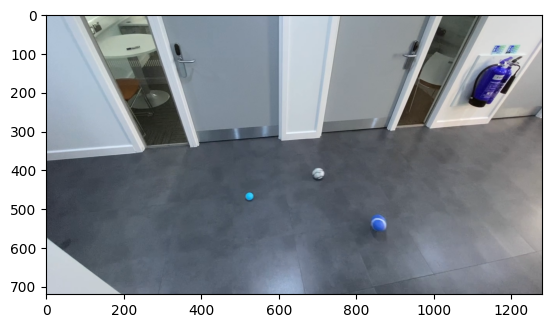

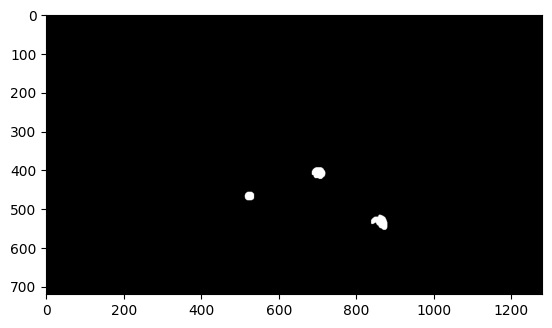

In [9]:
# unit test
import matplotlib.pyplot as plt
image = cv2.imread('ball_frames/frame-83.png')
ball_masks = balls_segment(image, kernel_size=5, area_min=200, area_max=3000)
plt.imshow(image, cmap='gray')
plt.show()
plt.imshow(ball_masks, cmap='gray')
plt.show()

## Task 1b

In [1]:
def calc_iou(gt, prediction):
    if gt.max() > 1:
        gt = gt / 255
    union = np.logical_or(gt, prediction)
    intersection = np.logical_and(gt, prediction)
    iou = np.sum(intersection) / np.sum(union)
    return iou

In [4]:
import os
import cv2
def calc_miou(folder, area_max=4000, min_area=200):
    miou = 0
    counter = 0
    iou_array = []
    image_array = []
    for image in os.listdir(folder):
        if image.endswith('.png'):
            name = image.split('.')[0]
            gt_path = os.path.join('ball_frames_gt', f'{name}_GT.png')
            image_path = os.path.join('ball_frames', image)
            gt_image = cv2.imread(gt_path)
            gt_image2 = cv2.cvtColor(gt_image, cv2.COLOR_BGR2GRAY)
            cv2.threshold(gt_image, 120, 255, cv2.THRESH_BINARY, gt_image)
            image = cv2.imread(image_path)
            image_segmented = balls_segment(image, area_max=area_max, area_min=min_area)
            cv2.imwrite(f'ball_frames_masks/{name}_mask.png', image_segmented)
            iou = calc_iou(gt_image, image_segmented)
            miou += iou
            counter += 1
            iou_array.append(iou)
            image_array.append(name.split('-')[-1])

    miou = miou / counter
    return miou, iou_array, image_array


In [5]:
miou , iou_array, image_array =  calc_miou('ball_frames', area_max=3000, min_area=200)

NameError: name 'balls_segment' is not defined

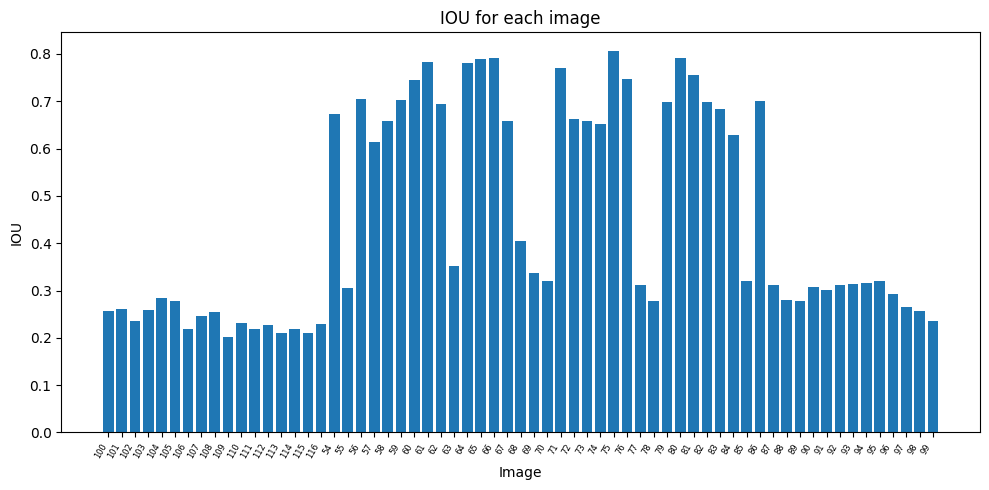

In [50]:
# Plotting
plt.figure(figsize=(10, 5))
plt.bar(image_array, iou_array)
plt.xlabel('Image')
plt.ylabel('IOU')
plt.title('IOU for each image')
plt.xticks(rotation=60, ha='right', fontsize=6)
plt.tight_layout()
plt.show()

In [51]:
mean_iou = np.mean(iou_array)
std_iou = np.std(iou_array)
print(f'Mean IOU: {mean_iou}')
print(f'Std IOU: {std_iou}')

Mean IOU: 0.44941426720093874
Std IOU: 0.22036045207047214


In [52]:
# picking top 5 images
top_5_images = sorted(zip(iou_array, image_array), reverse=True)[:5]
worst_5_images = sorted(zip(iou_array, image_array))[:5]

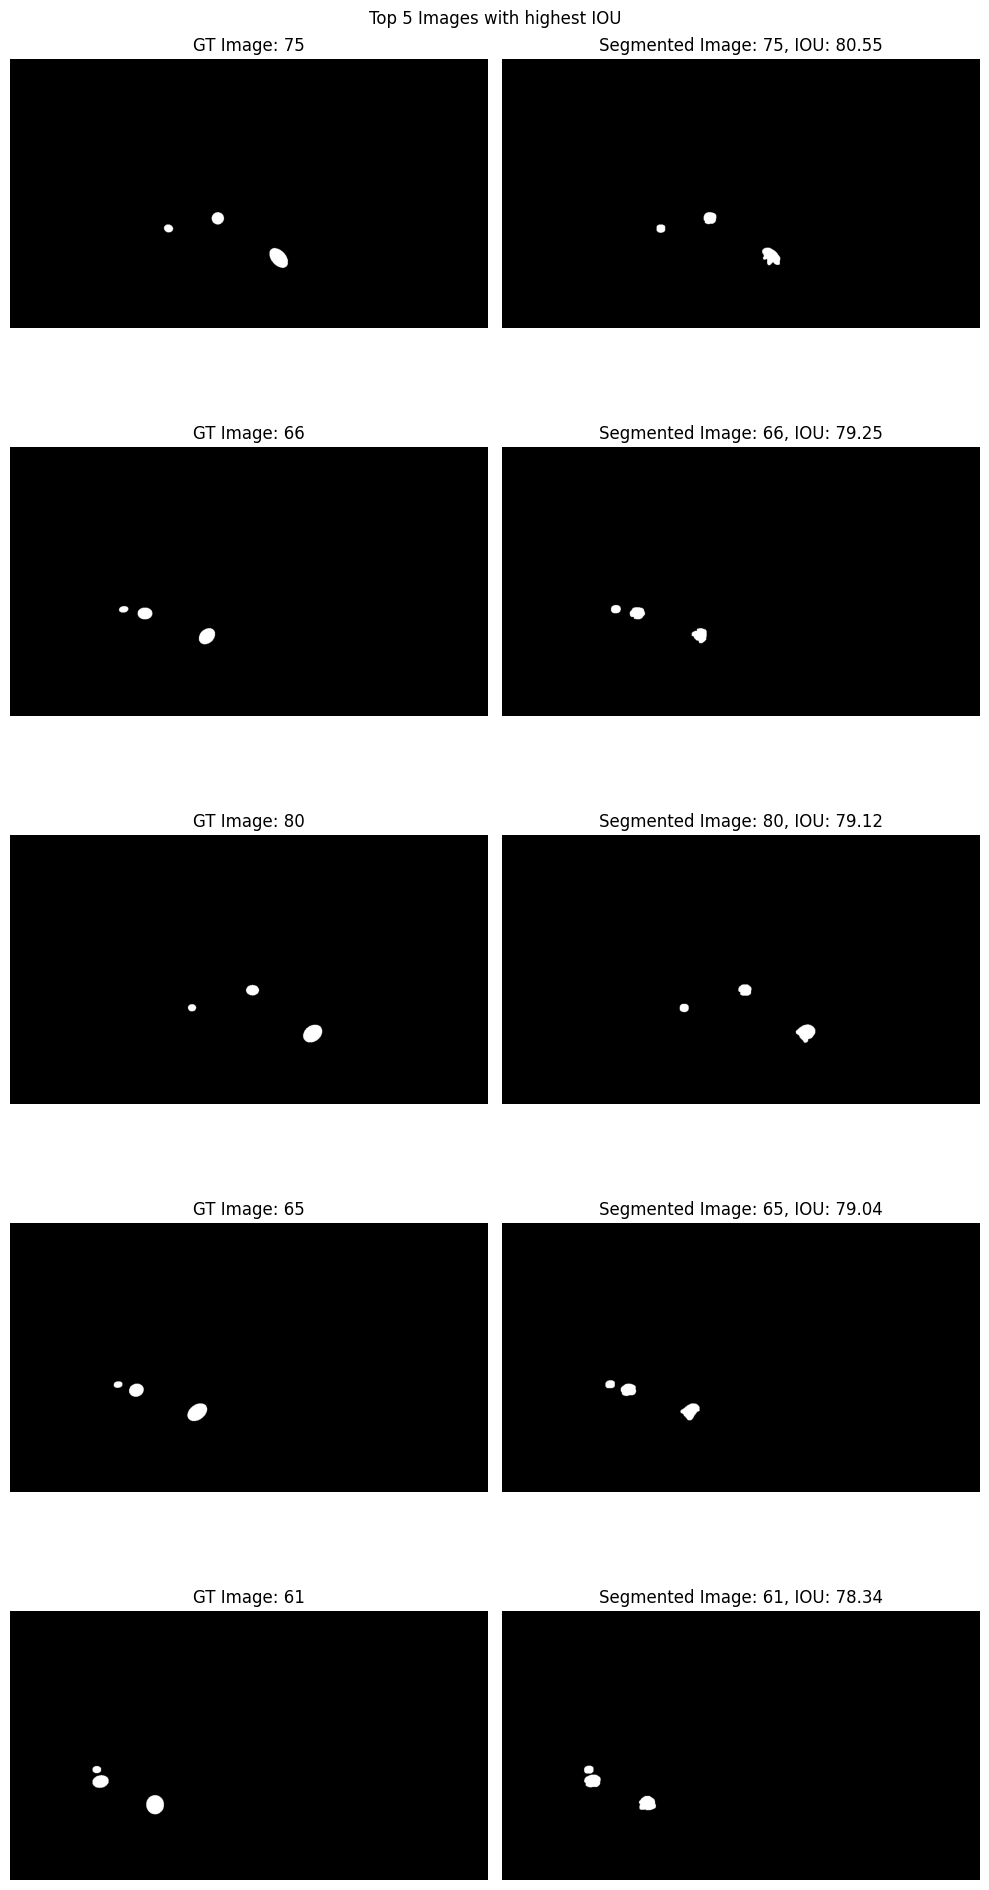

In [53]:
fig, axs = plt.subplots(5, 2, figsize=(10, 20))
for i, (iou, name) in enumerate(top_5_images):
    gt_path = os.path.join('ball_frames_gt', f'frame-{name}_GT.png')
    image_path = os.path.join('ball_frames', f'frame-{name}.png')
    gt_image = cv2.imread(gt_path)
    image = cv2.imread(image_path)
    image_segmented = cv2.imread(f'ball_frames_masks/frame-{name}_mask.png')
    axs[i, 0].imshow(gt_image, cmap='gray')
    axs[i, 0].set_title(f'GT Image: {name}')
    axs[i, 0].axis('off')
    axs[i, 1].imshow(image_segmented, cmap='gray')
    axs[i, 1].set_title(f'Segmented Image: {name}, IOU: {iou*100:.2f}')
    axs[i, 1].axis('off')
plt.tight_layout()
plt.suptitle('Top 5 Images with highest IOU')
plt.show()

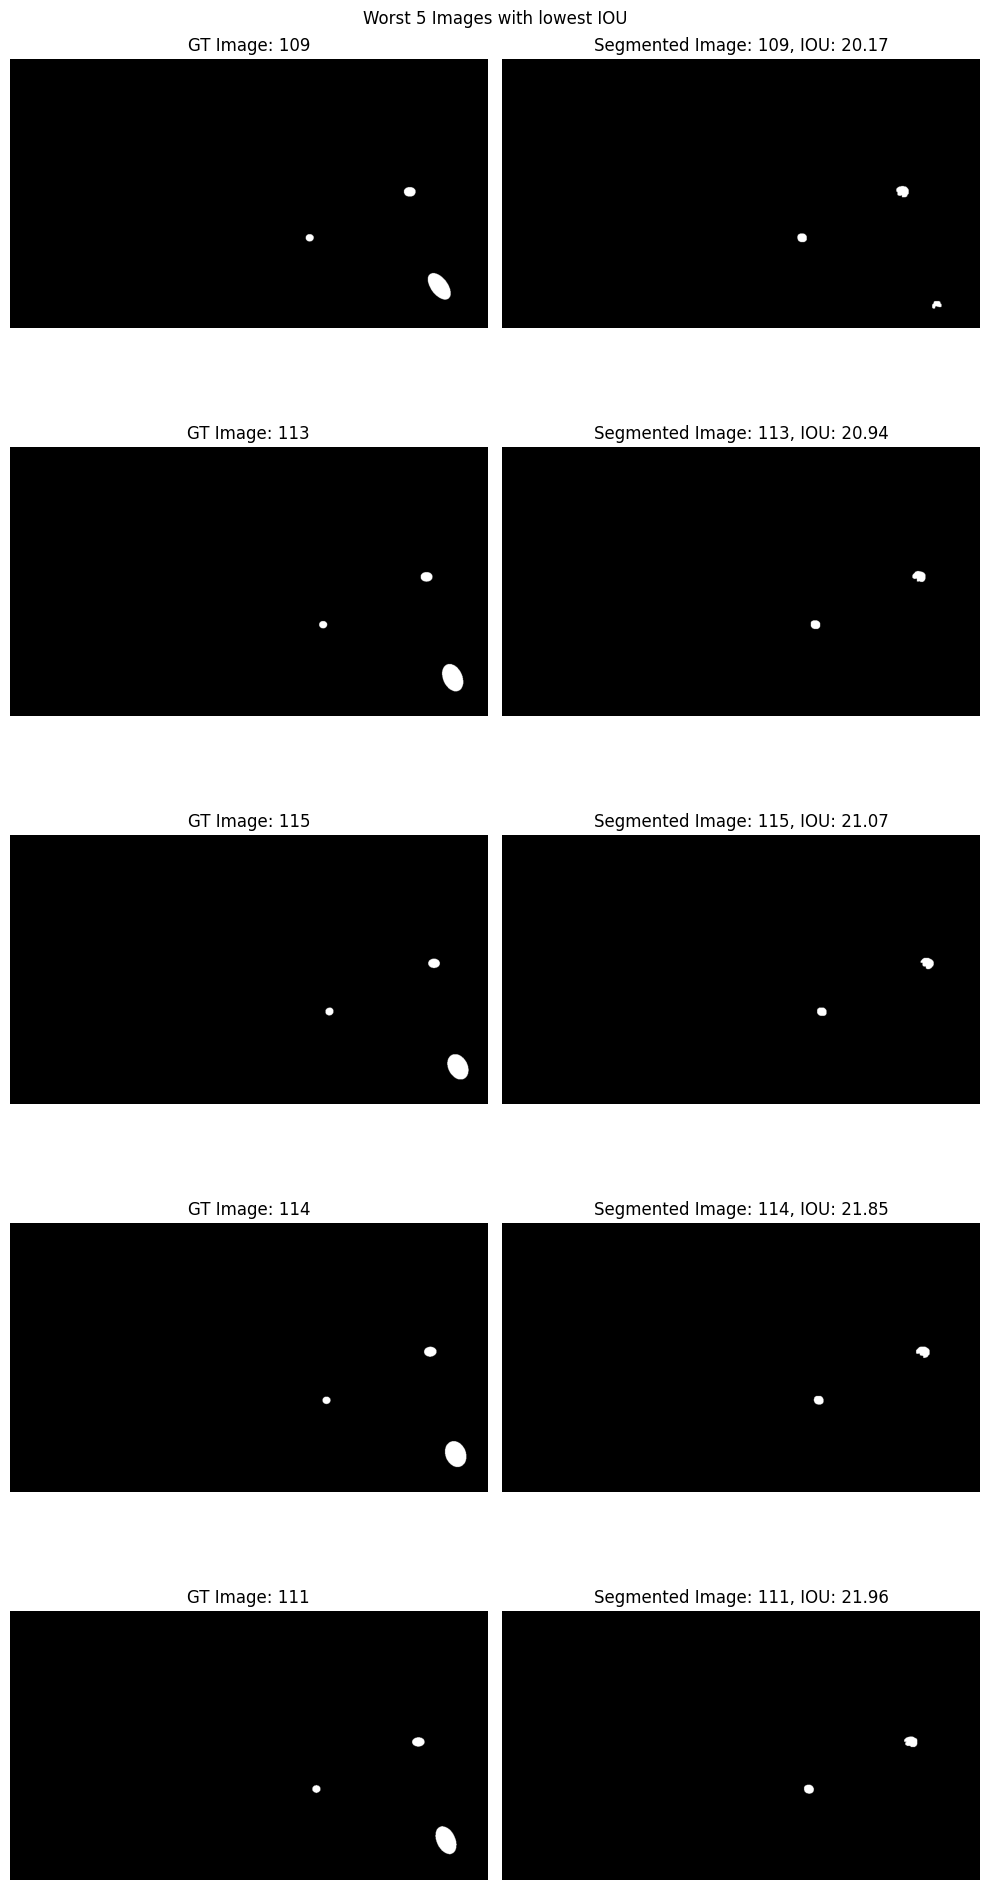

In [54]:
fig, axs = plt.subplots(5, 2, figsize=(10, 20))
for i, (iou, name) in enumerate(worst_5_images):
    gt_path = os.path.join('ball_frames_gt', f'frame-{name}_GT.png')
    image_path = os.path.join('ball_frames', f'frame-{name}.png')
    gt_image = cv2.imread(gt_path)
    image = cv2.imread(image_path)
    image_segmented = cv2.imread(f'ball_frames_masks/frame-{name}_mask.png')
    axs[i, 0].imshow(gt_image, cmap='gray')
    axs[i, 0].set_title(f'GT Image: {name}')
    axs[i, 0].axis('off')
    axs[i, 1].imshow(image_segmented, cmap='gray')
    axs[i, 1].set_title(f'Segmented Image: {name}, IOU: {iou*100:.2f}')
    axs[i, 1].axis('off')
plt.tight_layout()
plt.suptitle('Worst 5 Images with lowest IOU')
plt.show()

## Task 2: Feature Calculation

### Shape Features

In [55]:
import cv2
import glob

def load_images(folder_path):
    images = []
    file_paths = glob.glob(folder_path + '/*.png')
    for file_path in file_paths:
        image = cv2.imread(file_path)
        if image is not None:
            images.append(image)
    return images

def load_masks(folder_path, load_grayscale=True):
    masks = []
    file_paths = glob.glob(folder_path + '/*.png')
    for file_path in file_paths:
        if load_grayscale:
            mask = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
        else:
            mask = cv2.imread(file_path)
        if mask is not None:
            masks.append(mask)
    return masks

images = load_images("ball_frames")
masks = load_masks("ball_frames_gt")

if len(images) != len(masks):
    raise ValueError("Number of images and masks do not match!")

print("Number of images:", len(images))
print("Number of masks:", len(masks))

Number of images: 63
Number of masks: 63


In [56]:
image = images[0]
print("Image shape:", image.shape)
ball_masks = masks[0]
print("Mask shape:", ball_masks.shape)

Image shape: (720, 1280, 3)
Mask shape: (720, 1280)


In [57]:
import cv2
import numpy as np
from skimage import measure
import matplotlib.pyplot as plt

def calculate_shape_features(mask):
    binary_mask = cv2.threshold(mask, 0, 255, cv2.THRESH_BINARY)[1]
    num_labels, labels = cv2.connectedComponents(binary_mask)
    solidity = []
    non_compactness = []
    circularity = []
    eccentricity = []
    for label in range(1, num_labels):
        region_mask = np.uint8(labels == label)
        props = measure.regionprops(region_mask)

        if props: 
            prop = props[0]
            solidity.append(prop.solidity)
            non_compactness.append(prop.perimeter ** 2 / (4 * np.pi * prop.area))
            circularity.append((4 * np.pi * prop.area) / (prop.perimeter ** 2))
            eccentricity.append(prop.eccentricity)

    return solidity, non_compactness, circularity, eccentricity

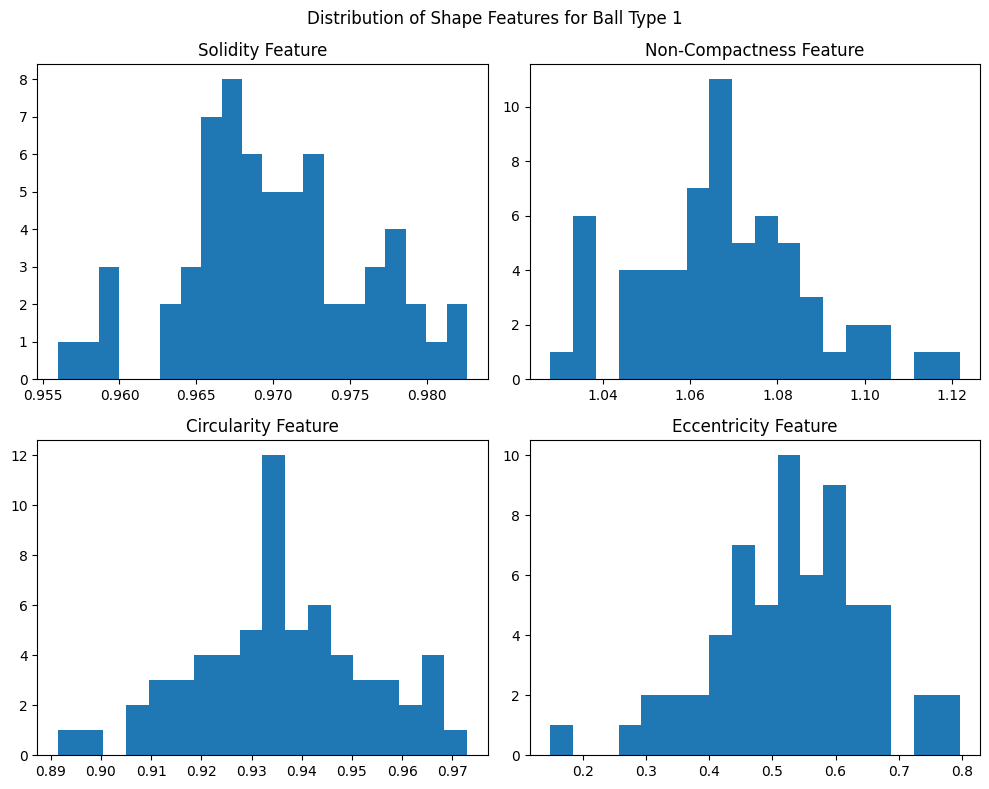

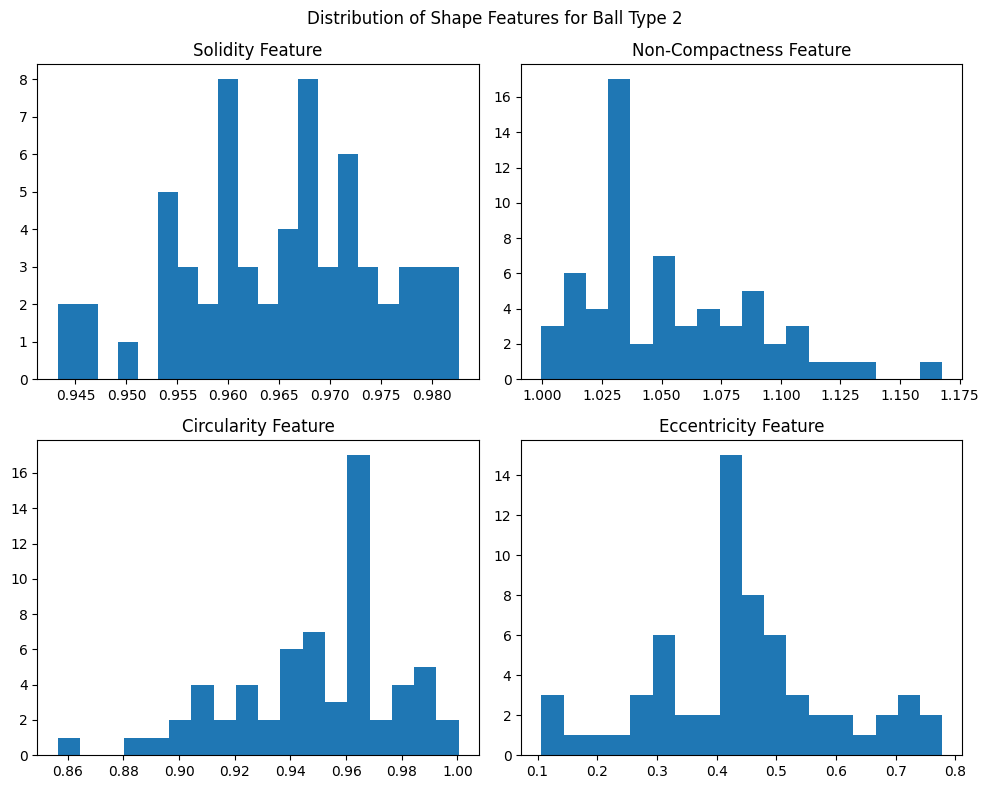

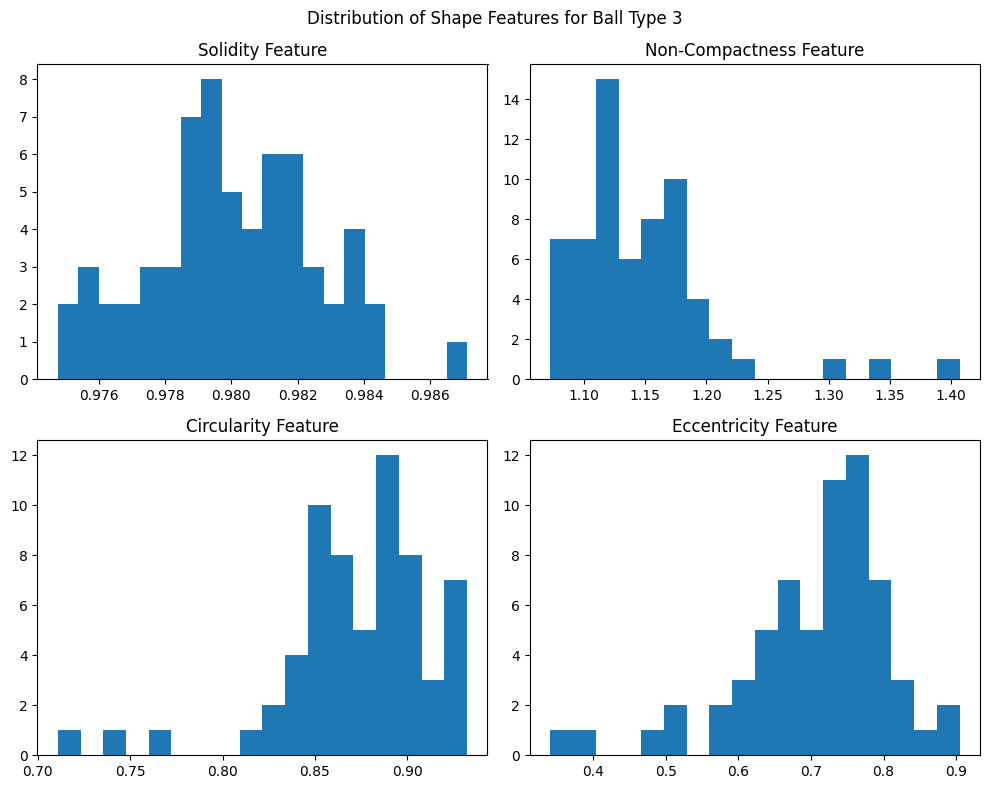

In [58]:
masks = load_masks("ball_frames_gt")
all_solidity = [[] for _ in range(3)]
all_non_compactness = [[] for _ in range(3)]
all_circularity = [[] for _ in range(3)]
all_eccentricity = [[] for _ in range(3)]

for ball_masks in masks:
    solidity, non_compactness, circularity, eccentricity = calculate_shape_features(ball_masks)
    
    for i in range(3):
        all_solidity[i].extend([solidity[i]])
        all_non_compactness[i].extend([non_compactness[i]])
        all_circularity[i].extend([circularity[i]])
        all_eccentricity[i].extend([eccentricity[i]])

for i in range(3):
    plt.figure(figsize=(10, 8))

    plt.subplot(2, 2, 1)
    plt.hist(all_solidity[i], bins=20)
    plt.title('Solidity Feature')

    plt.subplot(2, 2, 2)
    plt.hist(all_non_compactness[i], bins=18)
    plt.title('Non-Compactness Feature')

    plt.subplot(2, 2, 3)
    plt.hist(all_circularity[i], bins=18)
    plt.title('Circularity Feature')

    plt.subplot(2, 2, 4)
    plt.hist(all_eccentricity[i], bins=18)
    plt.title('Eccentricity Feature')

    plt.suptitle('Distribution of Shape Features for Ball Type {}'.format(i+1))
    plt.tight_layout()
    plt.show()


### Texture Features

In [59]:
import cv2
import numpy as np
from skimage.feature import graycomatrix, graycoprops
import matplotlib.pyplot as plt

def extract_texture_features(image, mask):

    patch = image * mask
    # normalize patch
    patch = cv2.normalize(patch, None, 0, 255, cv2.NORM_MINMAX)
    
    # find connected components
    gray = cv2.cvtColor(patch, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY)
    num_labels, labels = cv2.connectedComponents(binary)

    # for each connected component, calculate texture features
    ball_textures = []
    for label in range(1, num_labels):
        region_mask = np.uint8(labels == label)
        region = cv2.bitwise_and(patch, patch, mask=region_mask)
        channel_textures = []
        for channel in cv2.split(region):
            glcm_features = []
            for angle in [0, np.pi/4, np.pi/2, 3*np.pi/4]:
                glcm = graycomatrix(channel, distances=[1], angles=[angle])
                features = []
                for prop in ['contrast', 'correlation', 'homogeneity']:
                    features.append(graycoprops(glcm, prop)[0, 0])
                glcm_features.append(features)
            mean = np.mean(glcm_features, axis=0)
            _range = np.ptp(glcm_features, axis=0)
            channel_textures.append((mean, _range))
        ball_textures.append(channel_textures)

    return ball_textures

In [60]:
import cv2
import numpy as np
from skimage.feature import graycomatrix, graycoprops
import matplotlib.pyplot as plt

image_path = 'ball_frames/frame-114.png'
gt_path = 'ball_frames_gt/frame-114_GT.png'
image = cv2.imread(image_path)
ball_masks = cv2.imread(gt_path)

textures = extract_texture_features(image, ball_masks)
textures = np.array(textures)
# print shape of textures array
print(textures.shape)

# textures: (num_balls, num_channels, mean and range, num_features)
feature1_r = [[] for _ in range(3)]
feature1_g = [[] for _ in range(3)]
feature1_b = [[] for _ in range(3)]

for channel in range(3):
    for ball_id, ball in enumerate(textures):
        # [0][0] : mean of contrast
        feature1_r[ball_id].append(ball[channel][0][0])
        feature1_g[ball_id].append(ball[channel][0][0])
        feature1_b[ball_id].append(ball[channel][0][0])

# feature1_r, feature1_g, feature1_b: (num_balls, num_channels)

(3, 3, 2, 3)


In [61]:
import matplotlib.pyplot as plt

feature_dict = {0: 'Contrast', 1: 'Correlation', 2: 'Homogeneity'}
feature = 1
# Initialize lists to store features
feature1_r = [[] for _ in range(3)]
feature1_g = [[] for _ in range(3)]
feature1_b = [[] for _ in range(3)]

masks = load_masks("ball_frames_gt", load_grayscale=False)

for image, ball_masks in zip(images, masks):
    textures = extract_texture_features(image, ball_masks)
    for ball_id, ball in enumerate(textures):
        # [0] for mean, [1] for range
        feature1_r[ball_id].append(ball[0][0][feature])  # Red channel
        feature1_g[ball_id].append(ball[1][0][feature])  # Green channel
        feature1_b[ball_id].append(ball[2][0][feature])  # Blue channel


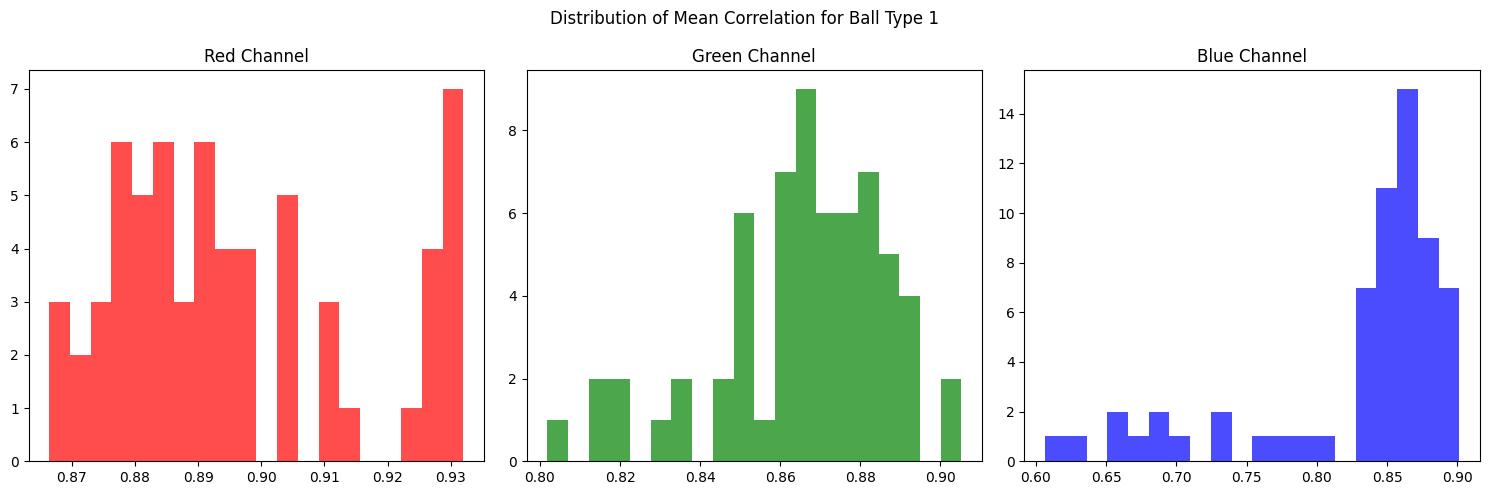

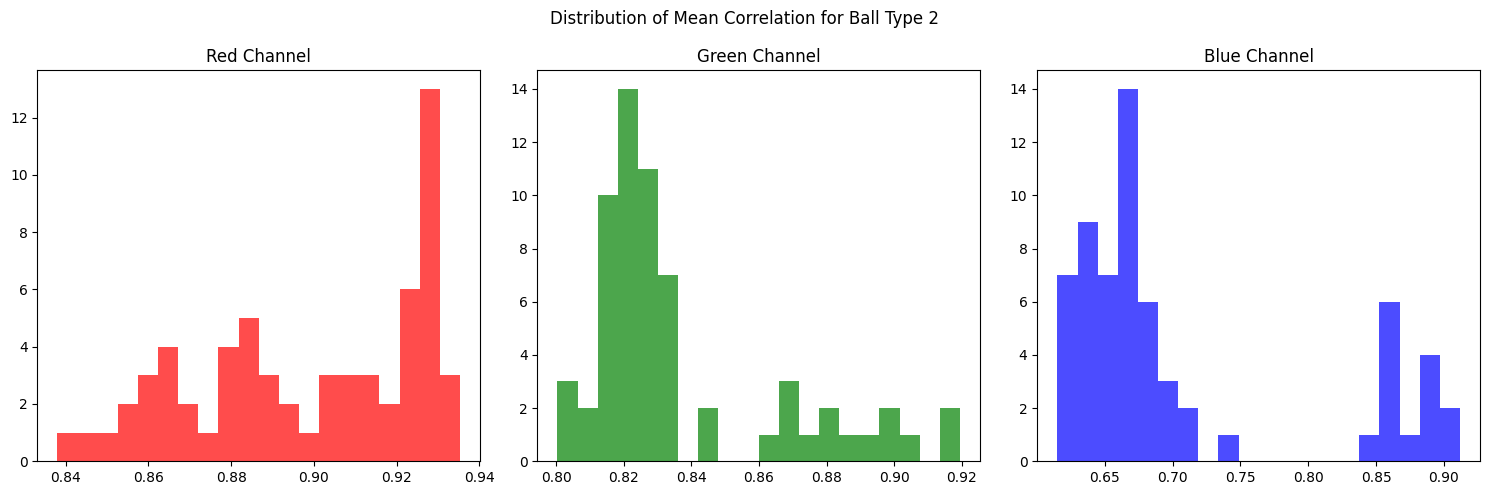

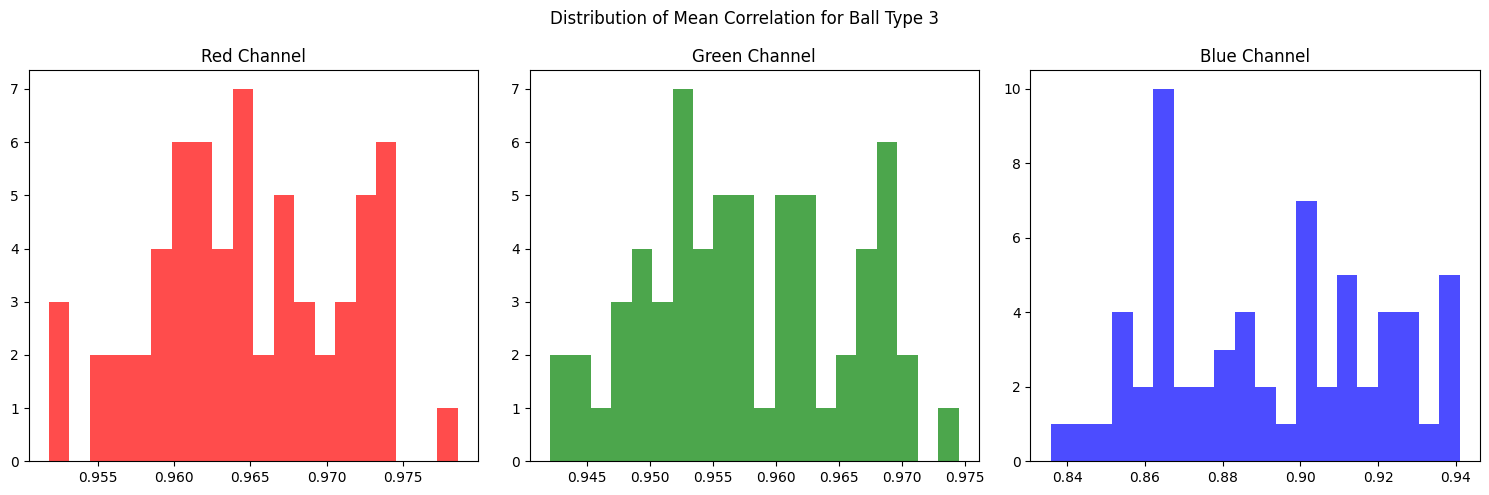

In [62]:
ball_types = ['Ball Type 1', 'Ball Type 2', 'Ball Type 3']
bins = 20
for i, ball_type in enumerate(ball_types):
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.hist(feature1_r[i], bins=bins, color='r', alpha=0.7)
    plt.title(f'Red Channel')

    plt.subplot(1, 3, 2)
    plt.hist(feature1_g[i], bins=bins, color='g', alpha=0.7)
    plt.title(f'Green Channel')

    plt.subplot(1, 3, 3)
    plt.hist(feature1_b[i], bins=bins, color='b', alpha=0.7)
    plt.title(f'Blue Channel')

    plt.suptitle(f'Distribution of Mean {feature_dict[feature]} for {ball_type}')

    plt.tight_layout()
    plt.show()